# The Model Complexity Myth

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2015/07/05/the-model-complexity-myth/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

## (or, Yes You Can Fit Models With More Parameters Than Data Points)

<!-- PELICAN_BEGIN_SUMMARY -->

An oft-repeated rule of thumb in any sort of statistical model fitting is "you can't fit a model with more parameters than data points".
This idea appears to be as wide-spread as it is incorrect.
On the contrary, if you construct your models carefully, **you can fit models with more parameters than datapoints**, and this is much more than mere trivia with which you can impress the nerdiest of your friends: as I will show here, this fact can prove to be very useful in real-world scientific applications.

A model with more parameters than datapoints is known as an *under-determined system*, and it's a common misperception that such a model cannot be solved in any circumstance.
In this post I will consider this misconception, which I like to call the "model complexity myth".
I'll start by showing where this model complexity myth holds true, first from from an intuitive point of view, and then from a more mathematically-heavy point of view.
I'll build from this mathematical treatment and discuss how underdetermined models may be addressed from a frequentist standpoint, and then from a Bayesian standpoint.
(If you're unclear about the general differences between frequentist and Bayesian approaches, I might suggest reading [my posts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) on the subject).
Finally, I'll discuss some practical examples of where such an underdetermined model can be useful, and demonstrate one of these examples: quantitatively accounting for measurement biases in scientific data.

<!-- PELICAN_END_SUMMARY -->

## The Root of the Model Complexity Myth

While the model complexity myth is not true in general, it is true in the specific case of simple linear models, which perhaps explains why the myth is so pervasive.
In this section I first want to motivate the reason for the underdetermination issue in simple linear models, first from an intuitive view, and then from a more mathematical view.

I'll start by defining some Python functions to create plots for the examples below; you can skip reading this code block for now:

In [1]:
# Code to create figures
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

def plot_simple_line():
    rng = np.random.RandomState(42)
    x = 10 * rng.rand(20)
    y = 2 * x + 5 + rng.randn(20)
    p = np.polyfit(x, y, 1)
    xfit = np.linspace(0, 10)
    yfit = np.polyval(p, xfit)
    plt.plot(x, y, 'ok')
    plt.plot(xfit, yfit, color='gray')
    plt.text(9.8, 1,
             "y = {0:.2f}x + {1:.2f}".format(*p),
             ha='right', size=14);
    
def plot_underdetermined_fits(p, brange=(-0.5, 1.5), xlim=(-3, 3),
                              plot_conditioned=False):
    rng = np.random.RandomState(42)
    x, y = rng.rand(2, p).round(2)
    xfit = np.linspace(xlim[0], xlim[1])
    for r in rng.rand(20):
        # add a datapoint to make model specified
        b = brange[0] + r * (brange[1] - brange[0])
        xx = np.concatenate([x, [0]])
        yy = np.concatenate([y, [b]])
        theta = np.polyfit(xx, yy, p)
        yfit = np.polyval(theta, xfit)
        plt.plot(xfit, yfit, color='#BBBBBB')
    plt.plot(x, y, 'ok')
    
    if plot_conditioned:
        X = x[:, None] ** np.arange(p + 1)
        theta = np.linalg.solve(np.dot(X.T, X)
                                + 1E-3 * np.eye(X.shape[1]),
                                np.dot(X.T, y))
        Xfit = xfit[:, None] ** np.arange(p + 1)
        yfit = np.dot(Xfit, theta)
        plt.plot(xfit, yfit, color='black', lw=2)

def plot_underdetermined_line():
    plot_underdetermined_fits(1)
        
def plot_underdetermined_cubic():
    plot_underdetermined_fits(3, brange=(-1, 2),
                            xlim=(0, 1.2))
    
def plot_conditioned_line():
    plot_underdetermined_fits(1, plot_conditioned=True)

### Fitting a Line to Data

The archetypical model-fitting problem is that of fitting a line to data:
A straight-line fit is one of the simplest of linear models, and is usually specified by two parameters: the slope *m* and intercept *b*.
For any observed value $x$, the model prediction for $y$ under the model $M$ is given by

$$
y_M = m x + b
$$

for some particular choice of $m$ and $b$.
Given $N$ obverved data points $\{x_i, y_i\}_{y=1}^N$, it is straightforward (see below) to compute optimal values for $m$ and $b$ which fit this data:

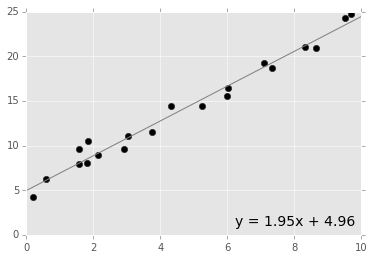

In [2]:
plot_simple_line()

The simple line-plus-intercept is a two-parameter model, and it becomes underdetermined when fitting it to fewer than two datapoints.
This is easy to understand intuitively: after all, you can draw any number of perfectly-fit lines through a single data point:

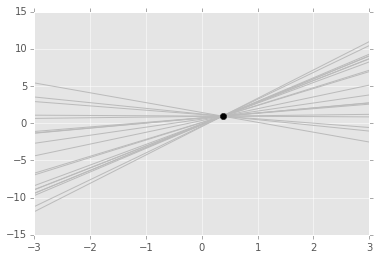

In [3]:
plot_underdetermined_line()

The single point simply isn't enough to pin-down both a slope and an intercept, and the model has no unique solution.

### Fitting a More General Linear Model

While it's harder to see intuitively, this same notion extends to simple linear models with more terms.
For example, let's think consider fitting a general cubic curve to data.
In this case our model is

$$
y_M = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3
$$

Note that this is still a linear model: the "linear" refers to the linearity of model parameters $\theta$ rather than linearity of the dependence on the data $x$.
Our cubic model is a four-parameter linear model, and just as a two-parameter model is underdetermined for fewer than two points, a four-parameter model is underdetermined for fewer than four points.
For example, here are some of the possible solutions of the cubic model fit to three randomly-chosen points:

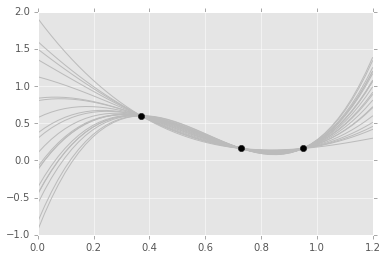

In [4]:
plot_underdetermined_cubic()

For any such simple linear model, an underdetermined system will lead to a similar result: an infinite set of best-fit solutions.

### The Mathematics of Underdetermined Models

To make more progress here, let's quickly dive into the mathematics behind these linear models.
Going back to the simple straight-line fit, we have our model

$$
y_M(x~|~\theta) = \theta_0 + \theta_1 x
$$

where we've replaced our slope $m$ and intercept $b$ by a more generalizable parameter vector $\theta = [\theta_0, \theta_1]$.
Given some set of data $\{x_n, y_n\}_{n=1}^N$ we'd like to find $\theta$ which gives the best fit.
For reasons I'll not discuss here, this is usually done by minimizing the sum of squared residuals from each data point, often called the $\chi^2$ of the model in reference to its expected theoretical distribution:

$$
\chi^2 = \sum_{n=1}^N [y_n - y_M(x_n~|~\theta)]^2
$$

We can make some progress by re-expressing this model in terms of matrices and vectors; we'll define the vector of $y$ values:

$$
y = [y_1, y_2, y_3, \cdots y_N]
$$

We'll also define the design matrix $X$; this contains all the information about the form of the model:

$$
X = \left[
\begin{array}{ll}
 1 & x_1 \\
 1 & x_2 \\
 \vdots &\vdots \\
 1 & x_N \\
\end{array}
\right]
$$

With this formalism, the vector of model values can be expressed as a matrix-vector product:

$$
y_M = X\theta
$$

and the $\chi^2$ can be expressed as a simple linear product as well:

$$
\chi^2 = (y - X\theta)^T(y - X\theta)
$$

We'd like to minimize the $\chi^2$ with respect to the parameter vector $\theta$, which we can do by the normal means of differentiating with respect to the vector $\theta$ and setting the result to zero (yes, you can take the derivative with respect to a vector!):

$$
\frac{d\chi^2}{d\theta} = -2X^T(y - X\theta) = 0
$$

Solving this for $\theta$ gives the *Maximum Likelihood Estimate (MLE)* for the parameters,

$$
\hat{\theta}_{MLE} = [X^T X]^{-1} X^T y
$$

Though this matrix formalism may seem a bit over-complicated, the nice part is that it straightforwardly generalizes to a host of more sophisticated linear models.
For example, the cubic model considered above requires only a larger design matrix $X$:

$$
X = \left[
\begin{array}{llll}
 1 & x_1 & x_1^2 & x_1^3\\
 1 & x_2 & x_2^2 & x_2^3\\
 \vdots & \vdots & \vdots & \vdots\\
 1 & x_N & x_N^2 & x_N^3\\
\end{array}
\right]
$$

The added model complexity is completely encapsulated in the design matrix, and the expression to compute $\hat{\theta}_{MLE}$ from $X$ is unchanged!

### Why Underdetermined Models Break

Taking a look at this Maximum Likelihood solution for $\theta$, we see that there is only one place that it might go wrong: the inversion of the matrix $X^T X$.
If this matrix is not invertible (i.e. if it is a singular matrix) then the maximum likelihood solution will not be well-defined.

The number of rows in $X$ corresponds to the number of data points, and the number of columns in $X$ corresponds to the number of parameters in the model.
It turns out that a matrix $C = X^TX$ will *always* be singular if $X$ has fewer rows than columns, and this is the source of the problem.
For underdetermined models, $X^TX$ is a singular matrix, and so the maximum likelihood fit is not well-defined.

Let's take a look at this in the case of fitting a line to the single point shown above, $(x=0.37, y=0.95)$.
For this value of $x$, here is the design matrix:

In [5]:
X = np.array([[1, 0.37]])

We can use this to compute the *normal matrix*, which is the standard name for $X^TX$:

In [6]:
C = np.dot(X.T, X)

If we try to invert this, we will get an error telling us the matrix is singular:

In [7]:
np.linalg.inv(C)

LinAlgError: Singular matrix

Evidently, if we want to fix the underdetermined model, we'll need to figure out how to modify the normal matrix so it is no longer singular.

### Fixing an Underdetermined Model: Conditioning

One easy way to make a singular matrix invertible is to *condition* it: that is, you add to it some multiple of the identity matrix before performing the inversion (in many ways this is equivalent to "fixing" a divide-by-zero error by adding a small value to the denominator).
Mathematically, that looks like this:

$$
C = X^TX + \sigma I
$$

For example, by adding $\sigma = 10^{-3}$ to the diagonal of the normal matrix, we condition the matrix so that it can be inverted:

In [8]:
cond = 1E-3 * np.eye(2)
np.linalg.inv(C + cond)

array([[ 121.18815362, -325.16038316],
       [-325.16038316,  879.69065823]])

Carrying this conditioned inverse through the computation, we get the following intercept and slope for our underdetermined problem:

In [9]:
b, m = np.linalg.solve(C + cond,
                       np.dot(X.T, [0.95]))
print("Conditioned best-fit model:")
print("y = {0:.3f} x + {1:.3f}".format(m, b))

Conditioned best-fit model:
y = 0.309 x + 0.835


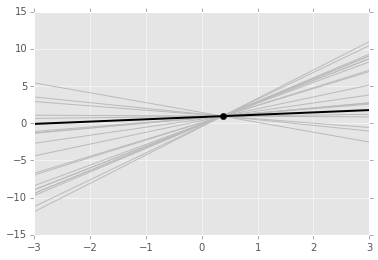

In [10]:
plot_conditioned_line()

This conditioning caused the model to settle on a particular one of the infinite possibilities for a perfect fit to the data.
Numerically we have fixed our issue, but this arbitrary conditioning is more than a bit suspect: why is this particular result chosen, and what does it actually mean in terms of our model fit?
In the next two sections, we will briefly discuss the meaning of this conditioning term from both a frequentist and Bayesian perspective.

## Frequentist Conditioning: Regularization

In a frequentist approach, this type of conditioning is known as *regularization*.
Regularization is motivated by a desire to penalize large values of model parameters.
For example, in the underdetermined fit above (with $(x, y) = (0.37, 0.95)$), you could fit the data perfectly with a slope of one billion and an intercept near negative 370 million, but in most real-world applications this would be a silly fit.
To prevent this sort of canceling parameter divergence, in a frequentist setting you can "regularize" the model by adding a penalty term to the $\chi^2$; one popular choice is a penalty term proportional to the sum of squares of the model parameters themselves:

$$
\chi^2_{reg} = \chi^2 + \lambda~\theta^T\theta
$$

Here $\lambda$ is the degree of regularization, which must be chosen by the person implementing the model.

Using the expression for the regularized $\chi^2$, we can minimize with respect to $\theta$ by again taking the derivative and setting it equal to zero:

$$
\frac{d\chi^2}{d\theta} = -2[X^T(y - X\theta) - \lambda\theta] = 0
$$

This leads to the following regularized maximum likelihood estimate for $\theta$:

$$
\hat{\theta}_{MLE} = [X^TX + \lambda I]^{-1} X^T y
$$

Comparing this to our conditioning above, we see that the regularization degree $\lambda$ is identical to the conditioning term $\sigma$ that we considered above.
That is, regulariation of this form is nothing more than a simple conditioning of $X^T X$, with $\lambda = \sigma$.
The result of this conditioning is to push the absolute values of the parameters toward zero, and in the process make an ill-defined problem solvable.

I'll add that the above form of regularization is known variably as *L2-regularization* or *Ridge Regularization*, and is only one of the possible regularization approaches.
Another useful form of regularization is *L1-regularization,* also known as *Lasso Regularization*, which has the interesting property that it favors sparsity in the model.

## Bayesian Conditioning: Priors

Regularization illuminates the meaning of matrix conditioning, but it still sometimes seems like a bit of black magic.
What does this penalization of model parameters within the $\chi^2$ actually mean?
Here, we can make progress in understanding the problem by examining regularization from a Bayesian perspective.

As I pointed out in my [series of posts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) on Frequentism and Bayesianism, for many simple problems, the frequentist likelihood (proportional to the negative exponent of the $\chi^2$) is equivalent to the Bayesian posterior (albeit with a subtlely but fundamentally different interpretation).

The Bayesian posterior probability on the model parameters $\theta$ is given by

$$
P(\theta~|~D, M) = \frac{P(D~|~\theta, M) P(\theta~|~M)}{P(D~|~M)}
$$

where the most important terms are the likelihood $P(D~|~\theta, M)$ and the prior $P(\theta~|~M)$.
From the expected correspondence with the frequentist result, we can write:

$$
P(D~|~\theta, M) P(\theta~|~M) \propto \exp[- \chi^2]
$$

Because the term on the right-hand-side has no $\theta$ dependence, we can immediately see that

$$
P(D~|~\theta, M) \propto \exp[-\chi^2]\\
P(\theta~|~M)  \propto 1
$$

That is, the simple frequentist likelihood is equivalent to the Bayesian posterior for the model with an implicit flat prior on $\theta$.

To understand the meaning of regularization, let's repeat this exercise with the regularized $\chi^2$:

$$
P(D~|~\theta, M) P(\theta~|~M) \propto \exp[- \chi^2 - \lambda~|\theta|^2]
$$

The regularization term in the $\chi^2$ becomes a second term in the product which depends only on $\theta$, thus we can immediately write

$$
P(D~|~\theta, M) \propto \exp[-\chi^2]\\
P(\theta~|~M)  \propto \exp[- \lambda~|\theta|^2]
$$

So we see that ridge regularization is equivalent to applying a Gaussian prior to your model parameters, centered at $\theta=0$ and with a width $\sigma_P = (2\lambda)^{-2}$.
This insight lifts the cover off the black box of regularization, and reveals that it is simply a roundabout way of adding a Bayesian prior within a frequentist paradigm.
The stronger the regularization, the narrower the implicit Gaussian prior is.

Returning to our single-point example above, we can quickly see how this intuition explains the particular model chosen by the regularized fit; it is equivalent to fitting the line while taking into account prior knowledge that both the intercept and slope should be near zero:

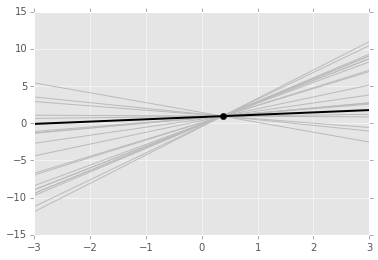

In [11]:
plot_conditioned_line()

The benefit of the Bayesian view is that it helps us understand exactly what this conditioning means for our model, and given this understanding we can easily extend use more general priors.
For example, what if you have reason to believe your slope is near 1, but have no prior information on your intercept?
In the Bayesian approach, it is easy to add such information to your model in a rigorous way.

But regardless of which approach you use, this central fact remains clear: you **can** fit models with more parameters than data points, if you restrict your parameter space through the use of frequentist regularization or Bayesian priors.

## Underdetermined Models in Action

There are a few places where these ideas about underdetermined models come up in real life.
I'll briefly discuss a couple of them here, and then walk through the solution of a simple (but rather interesting) problem that demonstrates these ideas.

### Compressed Sensing: Image Reconstruction

One area where underdetermined models are often used is in the area of *Compressed Sensing*.
Compressed sensing comprises a set of models in which underdetermined linear systems are solved using a sparsity prior,
the classic example of which is the reconstruction of a full image from just a handful of its pixels.
As a simple linear model this would fail, because there are far more unknown pixels than known pixels.
But by carefully training a model on the structure of typical images and applying priors based on sparsity, this seemingly impossible problem becomes tractable.
This [2010 Wired article](http://www.wired.com/2010/02/ff_algorithm/) has a good popular-level discussion of the technique and its applications, and includes this image showing how a partially-hidden input image can be iteratively reconstructed from a handful of pixels using a sparsity prior:

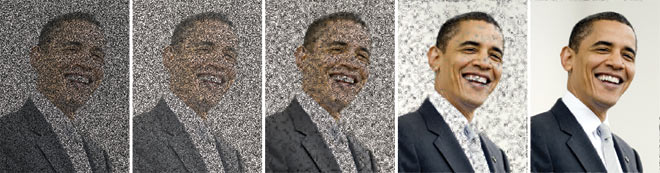

In [12]:
from IPython.display import Image
Image('http://www.wired.com/magazine/wp-content/images/18-03/ff_algorithm2_f.jpg')

### Kernel-based Methods: Gaussian Processes

Another area where a classically underdetermined model is solved is in the case of *Gaussian Process Regression*.
Gaussian Processes are an interesting beast, and one way to view them is that rather than fitting, say, a two-parameter line or four-parameter cubic curve, they actually fit an *infinite-dimensional* model to data!
They accomplish this by judicious use of certain priors on the model, along with a so-called "kernel trick" which solves the infinite dimensional regression implicitly using a finite-dimensional representation constructed based on these priors.

In my opinion, the best resource to learn more about Gaussian Process methods is the [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) book, which is available for free online (though it is a bit on the technical side).
You might also take a look at the [scikit-learn Gaussian Process](http://scikit-learn.org/stable/modules/gaussian_process.html) documentation.
If you'd like to experiment with a fast and flexible Gaussian Process implementation in Python, check out the [``george``](http://dan.iel.fm/george/current/) library.

### Imperfect Detectors: Extrasolar Planets

Another place I've seen effective use of the above ideas is in situations where the data collection process has unavoidable imperfections or biases.
There are two basic ways forward when working with such noisy and biased data:

- you can pre-process the data to try to remove and/or correct data imperfections, and then fit a conventional model to the corrected data.
- you can account for the data imperfections along with interesting model parameters as part of a unified model: this type of unified approach is often preferable in scientific settings, where even the most careful pre-processing can lead to biased results.

If you'd like to see a great example of this style of forward-modeling analysis, check out the efforts of David Hogg's group in finding extrasolar planets in the Kepler survey's K2 data; there's a [nice astrobytes post](http://astrobites.org/2015/02/23/no-need-for-de-trending-finding-exoplanets-in-k2/) which summarizes some of these results.
While the group hasn't yet published any results based on truly underdetermined models, it is easy to imagine how this style of comprehensive forward-modeling analysis could be pushed to such an extreme.

### Example: Fitting a Model to Biased Data

While it might be fun to dive into the details of models for noisy exoplanet searches, I'll defer that to the experts.
Instead, as a more approachable example of an underdetermined model, I'll [revisit](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) a toy example in which a classically underdetermined model is used to account for imperfections in the input data.

Imagine you have some observed data you would like to model, but you know that your detector is flawed such that some observations (you don't know which) will have a bias that is not reflected in the estimated error: in short, there are outliers in your data.
How can you fit a model to this data while accounting for the possibility of such outliers?

To make this more concrete, consider the following data, which is drawn from a line with noise, and includes several outliers:

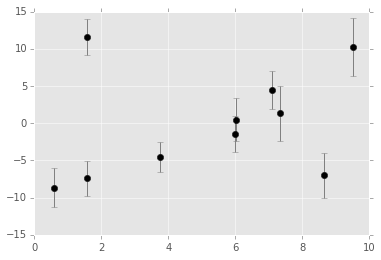

In [13]:
rng = np.random.RandomState(42)
theta = [-10, 2]
x = 10 * rng.rand(10)
dy = 2 + 2 * rng.rand(10)
y = theta[0] + theta[1] * x + dy * rng.randn(10)
y[4] += 15
y[7] -= 10
plt.errorbar(x, y, dy, fmt='ok', ecolor='gray');

If we try to fit a line using the standard $\chi^2$ minimization approach, we will find an obviously biased result:

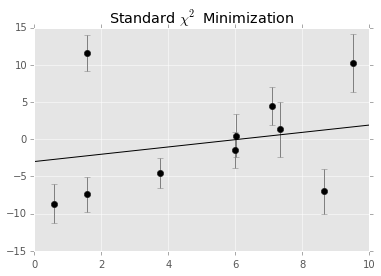

In [14]:
from scipy import optimize

def chi2(theta, x=x, y=y, dy=dy):
    y_model = theta[0] + theta[1] * x
    return np.sum(0.5 * ((y - y_model) / dy) ** 2)

theta1 = optimize.fmin(chi2, [0, 0], disp=False)

xfit = np.linspace(0, 10)
plt.errorbar(x, y, dy, fmt='ok', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Standard $\chi^2$ Minimization');

This reflects a well-known deficiency of $\chi^2$ minimization: it is not robust to the presence of outliers.

What we would like to do is propose a model which somehow accounts for the possibility that each of these points *may* be the result of a biased measurement.
One possible route is to add $N$ new model parameters: one associated with each point which indicates whether it is an outlier or not.
If it is an outlier, we use the standard model likelihood; if not, we use a likelihood with a much larger error.
The result for our straight-line fit will be a model with $N + 2$ parameters, where $N$ is the number of data points.
An overzealous application of lessons from simple linear models might lead you to believe this model can't be solved.
But, if carefully constructed, it can! Let's see how it can be done.

Our linear model is:

$$
y_M(x~|~\theta) = \theta_0 + \theta_1 x
$$

For a non-outlier (let's call it an "inlier") point at $x$, $y$, with error on $y$ given by $dy$, the likelihood is

$$
L_{in, i}(D~|~\theta) = \frac{1}{\sqrt{2\pi dy_i^2}} \exp\frac{-[y_i - y_M(x_i~|~\theta)]^2}{2 dy_i^2}
$$

For an "outlier" point, the likelihood is

$$
L_{out, i}(D~|~\theta) = \frac{1}{\sqrt{2\pi \sigma_y^2}} \exp\frac{-[y_i - y_M(x_i~|~\theta)]^2}{2 \sigma_y^2}
$$

where $\sigma_y$ is the standard deviation of the $y$ data: note that the only difference between the "inlier" and "outlier" likelihood is the width of the Gaussian distribution.

Now we'll specify $N$ additional binary model parameters $\{g_i\}_{i=1}^N$ which indicate whether point $i$ is an outlier $(g_i = 1)$ or an inlier $(g_i = 0)$.
With this, the overall Likelihood becomes:

$$
L(D~|~\theta, g) = \prod_i \left[(1 - g_i)~L_{in, i} + g_i~L_{out, i}\right]
$$

We will put a prior on these indicator variables $g$ which encourages sparsity of outliers; this can be accomplished with a simple L1 prior, which penalizes the sum of the $g$ terms:

$$
P(g) = \exp\left[-\sum_i g_i\right]
$$

where, recall, $g_i \in \{0, 1\}$.

Though you could likely solve for a point estimate of this model, I find the Bayesian approach to be much more straightforward and interpretable for a model this complex.
To fit this, I'll make use of the excellent [``emcee`` package](http://dan.iel.fm/emcee/current/).
Because emcee doesn't have categorical variables, we'll instead allow $g_i$ to range continuously between 0 and 1, so that any single point will be some mixture of "outlier" and "inlier".

We start by defining a function which computes the log-posterior given the data and model parameters, using some computational tricks for the sake of floating-point accuracy:

In [15]:
# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i

def log_prior(theta):
    g = theta[2:]
    #g_i needs to be between 0 and 1
    if (np.any(g < 0) or np.any(g > 1)):
        return -np.inf # recall log(0) = -inf
    else:
        return -g.sum()

def log_likelihood(theta, x, y, dy):
    sigma_y = np.std(y)
    y_model = theta[0] + theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    # log-likelihood for in-lier
    logL_in = -0.5 * (np.log(2 * np.pi * dy ** 2) + ((y - y_model) / dy)** 2)
    # log-likelihood for outlier
    logL_out = -0.5 * (np.log(2 * np.pi * sigma_y ** 2) + ((y - y_model) / sigma_y) ** 2)
    return np.sum(np.logaddexp(np.log(1 - g) + logL_in,
                               np.log(g) + logL_out))

def log_posterior(theta, x, y, dy):
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

Now we use the ``emcee`` package to run this model.
Note that because of the high dimensionality of the model, the ``run_mcmc`` command below will take a couple minutes to complete:

In [16]:
import emcee

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set walkers near the maximum likelihood
# adding some random scatter
rng = np.random.RandomState(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = rng.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = rng.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, dy])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

-c:21: RuntimeWarning: divide by zero encountered in log
-c:22: RuntimeWarning: divide by zero encountered in log


The Runtime warnings here are normal – they just indicate that we've hit ``log(0) = -inf`` for some pieces of the calculation.

With the sample chain determined, we can plot the marginalized distribution of samples to get an idea of the value and uncertainty of slope and intercept with this model:

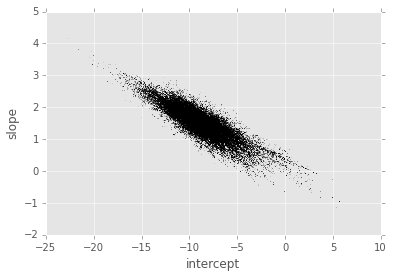

In [17]:
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

These points describe the marginalized posterior distribution of the slope and intercept for our model given the data.

Finally, we can make use of the marginalized values of all $N + 2$ parameters and plot both the best-fit model, along with a model-derived indication of whether each point is an outlier:

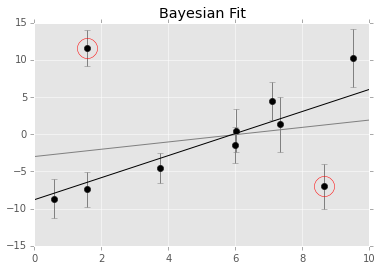

In [18]:
theta2 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g > 0.5)

plt.errorbar(x, y, dy, fmt='ok', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='gray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Bayesian Fit');

The red circles mark the points that were determined to be outliers by our model, and the black line shows the marginalized best-fit slope and intercept.
For comparison, the grey line is the standard maximum likelihood fit.

Notice that we have successfully fit an $(N + 2)$-parameter model to $N$ data points, and the best-fit parameters are actually *meaningful* in a deep way – the $N$ extra parameters give us individual estimates of whether each of the $N$ data points has misreported errors.
I think this is a striking example of the practical use of a model which might seem impossible under the model complexity myth!

## Conclusion

I hope you will see after reading this post that the model complexity myth, while rooted in a solid understanding of simple linear models, should not be assumed to apply to all possible models.
In fact, **it is possible to fit models with more parameters than datapoints**: and for the types of noisy, biased, and heterogeneous data we often encounter in scientific research, you can make a lot of progress by taking advantage of such models.
Thanks for reading!

*This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/ModelComplexityMyth.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/ModelComplexityMyth.ipynb).*